<a href="https://colab.research.google.com/github/oenereaty/MP2024/blob/main/MP2024_quiz4(1)_%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%8C%9C%ED%95%99%EA%B3%BC_%EC%B1%84%EA%B2%BD%EC%9B%90(202321639)_%EA%B0%9C%EC%9D%B8%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [1]:
pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00


In [2]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np

In [7]:
beans = datasets.load_dataset('beans')
beans

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

# 데이터 전처리하기

In [33]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
def transforms(examples):
    _transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    examples["pixel_values"] = [_transforms(img) for img in examples["image"]]
    del examples["image"]
    return examples
beans = beans.with_transform(transforms)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


# 인공지능을 생성하기 위한 준비

In [34]:
labels = beans["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# 인공지능 생성하기

In [35]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 트레이너 생성 준비

In [36]:
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)

# 트레이너 생성하기

In [37]:
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=beans["train"],
    eval_dataset=beans["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

# 학습하기

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.992900,0.653855,0.890625
1,0.483400,0.398120,0.914062
2,0.378300,0.345158,0.945312


TrainOutput(global_step=48, training_loss=0.5860410829385122, metrics={'train_runtime': 152.2145, 'train_samples_per_second': 20.379, 'train_steps_per_second': 0.315, 'total_flos': 2.3712761350139904e+17, 'train_loss': 0.5860410829385122, 'epoch': 2.953846153846154})

# 평가하기

In [40]:
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-48")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# 짱 신기하다

In [61]:
라벨 = beans["train"].features["labels"].names
라벨

['angular_leaf_spot', 'bean_rust', 'healthy']

In [52]:
hmm = datasets.load_dataset('beans')

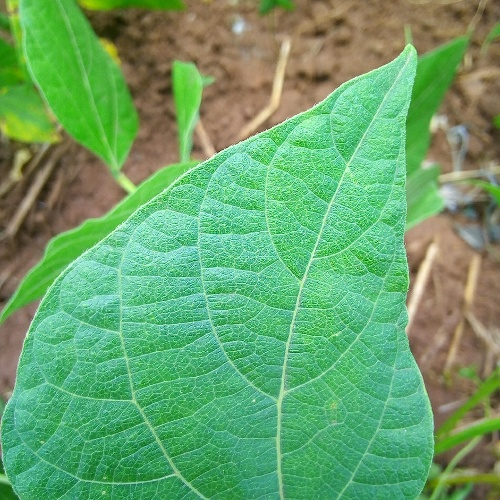

In [65]:
image = hmm['train'][693]['image']
image

In [66]:
classifier(image)

[{'label': 'healthy', 'score': 0.8543656468391418},
 {'label': 'angular_leaf_spot', 'score': 0.32664668560028076},
 {'label': 'bean_rust', 'score': 0.2937808632850647}]

In [68]:
{key: {i:beans[key]['labels'].count(i) for i in set(beans[key]['labels'])} for key in beans}

{'train': {0: 345, 1: 348, 2: 341},
 'validation': {0: 44, 1: 45, 2: 44},
 'test': {0: 43, 1: 43, 2: 42}}